In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

# Import and process the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Autoencoders

/content/drive/MyDrive/Course Material/Supervised Machine Learning/Autoencoders


In [4]:
data = pd.read_csv('mnist_train.csv')

In [5]:
data = np.array(data)
data = data[0:10000,:] # Extracting first 10000 samples
data.shape

(10000, 785)

In [6]:
# Data without labels because Unsupervised learning
data = data[:,1:]

# Data Normalization
dataN = data / np.max(data)

# Converting to pytorch tensor
dataT = torch.tensor( dataN, dtype = torch.float32)

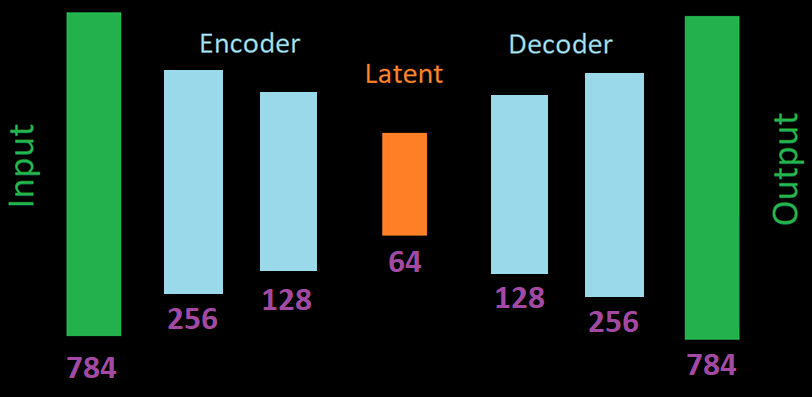

# Create Autoencoder Using Class

In [7]:
class AE_Model(nn.Module):
  def __init__(self):
    super().__init__()

    # Input Layer

    self.input = nn.Linear(784,256)

    # Encoder Layers

    self.encoder1 = nn.Linear(256,128)
    self.encoder2 = nn.Linear(128,64)

    # Latent Layer

    self.latent = nn.Linear(64,128)

    # Decoder Layers

    self.decoder1 = nn.Linear(128,256)
    self.decoder2 = nn.Linear(256,784)


  def forward(self,x):

    # Input Layer

    x = F.relu( self.input(x) )

    # Encoder Layers

    x = F.relu( self.encoder1(x) )
    x = F.relu( self.encoder2(x) )

    # Latent Layer

    x = F.relu( self.latent(x) )

    # Decoder Layers

    x = F.relu( self.decoder1(x) )
    x = torch.sigmoid( self.decoder2(x) )
    return x

# Creating Model Instance and Setting Parameters

In [8]:
model = AE_Model()

lossfunc = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=.001)

# Train the Model

In [ ]:
epochs = 15001

losses = torch.zeros(epochs)

for epoch in range(epochs):

  # Selecting a batchsize  of 32.

  random_idx = np.random.choice(dataT.shape[0], size=32)

  X = dataT[random_idx,:]
  ypred = model(X)
  loss = lossfunc(ypred,X)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  losses[epoch] = loss.item()

  if (epoch % 1000) == 0:

      print(f' epochs : {epoch}  loss : {loss : 2.2f}')

 epochs : 0  loss :  0.23
 epochs : 1000  loss :  0.03
 epochs : 2000  loss :  0.02
 epochs : 3000  loss :  0.02
 epochs : 4000  loss :  0.01
 epochs : 5000  loss :  0.01
 epochs : 6000  loss :  0.01
 epochs : 7000  loss :  0.01
 epochs : 8000  loss :  0.01
 epochs : 9000  loss :  0.01
 epochs : 10000  loss :  0.01
 epochs : 11000  loss :  0.01
 epochs : 12000  loss :  0.01
 epochs : 13000  loss :  0.01
 epochs : 14000  loss :  0.01
 epochs : 15000  loss :  0.01


# Performance Visualization

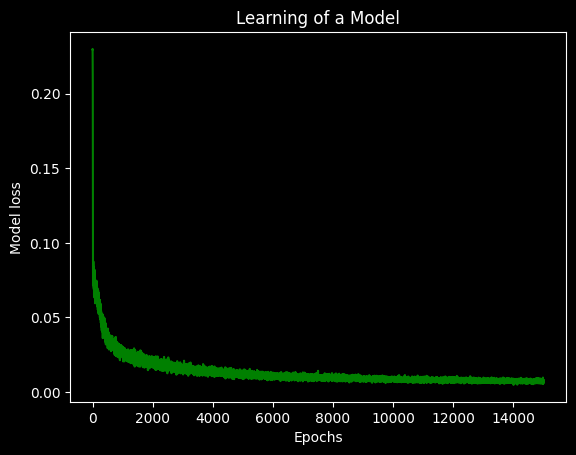

In [ ]:
plt.plot(losses, color = 'g', ls = '-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Learning of a Model')
plt.show()

# Model Testing

In [ ]:
X = dataT[:7,:]  # Extracting first seven samples
ypred = model(X)

In [ ]:
X.shape

torch.Size([7, 784])

# Visualizing Test Performance

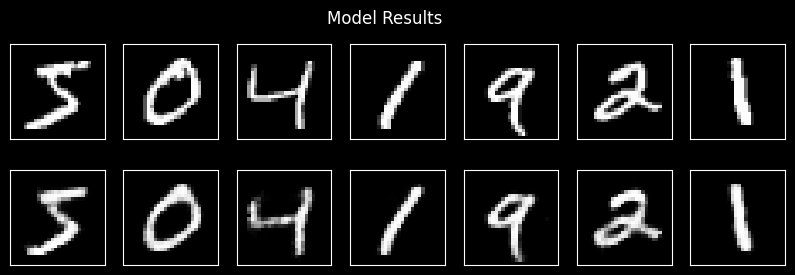

In [ ]:
fig,axes = plt.subplots(2,7,figsize=(10,3))

for i in range(7):
  axes[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axes[1,i].imshow(ypred[i,:].view(28,28).detach() ,cmap='gray')
  axes[0,i].set_xticks([]), axes[0,i].set_yticks([])
  axes[1,i].set_xticks([]), axes[1,i].set_yticks([])

plt.suptitle('Model Results')
plt.show()

# Autoencoder as an Image Classifier

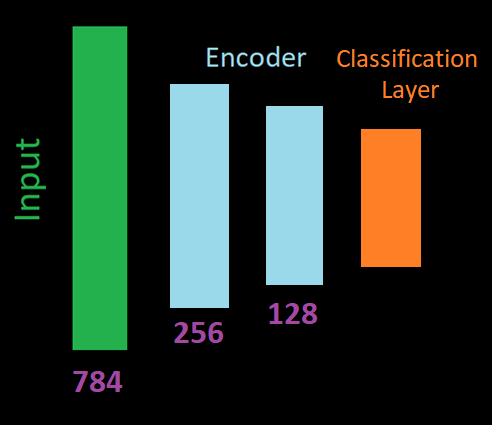

# Classification by Autoencoder (Supervised Learning)

In [9]:
class AE_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # Input Layer

    self.input = nn.Linear(784,256)

    # Encoder Layers

    self.encoder1 = nn.Linear(256,128)
    self.encoder2 = nn.Linear(128,64)

    # Output Layer

    self.output = nn.Linear(64,10)



  def forward(self,x):

    # Input Layer

    x = F.relu( self.input(x) )

    # Encoder Layers

    x = F.relu( self.encoder1(x) )
    x = F.relu( self.encoder2(x) )

    # Output Layer

    x = self.output(x)
    return x

# Create Model Instance

In [10]:
model = AE_Classifier()

# Read the data for classification purpose

In [11]:
data = pd.read_csv('mnist_train.csv')

In [12]:
data = np.array(data)
data = data[0:10000,:] # Extracting first 10000 samples

# Extracting Features and Labels

In [13]:
X = data[:,1:]
y = data[:,0]

# Four Important Steps

In [14]:
# Step 1: Convert to pytorch tensor
X_t   = torch.tensor( X, dtype = torch.float32 )
y_t = torch.tensor( y, dtype = torch.long)

# Step 2: Perform Train Test Split and Normalize the data
train_data, test_data, train_labels, test_labels = train_test_split(X_t, y_t, test_size = 0.1)

train_data = train_data/torch.max(train_data)
test_data  = test_data/torch.max(test_data)


# Step 3: Convert into PyTorch Datasets
X_train = TensorDataset(train_data,train_labels)
X_test  = TensorDataset(test_data,test_labels)


# Step 4: Move the data into dataloader objects
batchsize    = 32
train_loader = DataLoader(X_train, batch_size = batchsize, shuffle = True, drop_last=True)
test_loader  = DataLoader(X_test, batch_size = X_test.tensors[0].shape[0])

# For Classification Use GPU

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Train and Test the Model

In [16]:
epochs = 101

lossfunc = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01)

model.to(device) # placing a model on GPU

# Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# For Loop for epochs

for epoch in range(epochs):
 model.train()

 # Loop for training in batches

 batchAcc  = []
 batchLoss = []

 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = model(X)
  loss = lossfunc(ypred,y)

# Backpropagation

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = model(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.49
 epochs : 10  loss :  0.01
 epochs : 20  loss :  0.00
 epochs : 30  loss :  0.00
 epochs : 40  loss :  0.00
 epochs : 50  loss :  0.00
 epochs : 60  loss :  0.00
 epochs : 70  loss :  0.00
 epochs : 80  loss :  0.00
 epochs : 90  loss :  0.00
 epochs : 100  loss :  0.00


# Visualize Classification Performance

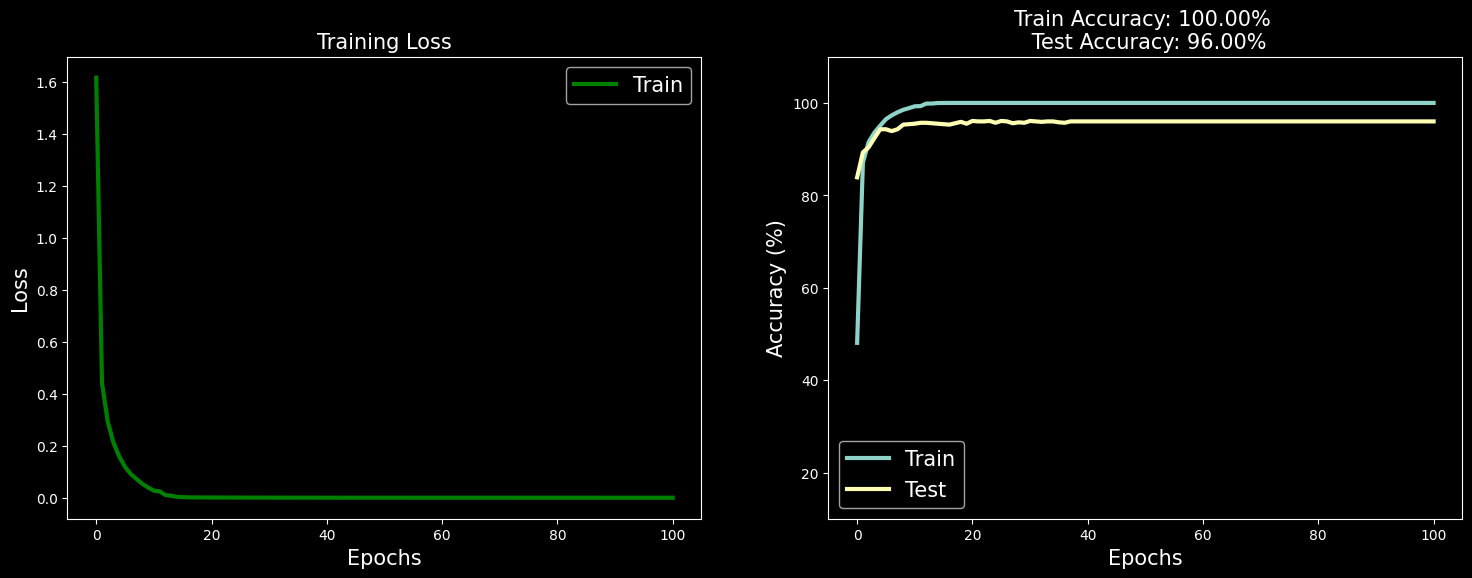

In [17]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()